In [66]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data
from skimage.filters import threshold_multiotsu
from scipy.sparse import diags, eye
from scipy.sparse.linalg import spsolve

matplotlib.rcParams['font.size'] = 9

## Multi-scale image representation
We are smoothing out the image here using the method described in 2.1 section of the paper

In [67]:
# Setting up the variables
lam = 0.3
alpha = 1
epsilon = 0.0001

# Loading the image 
image_path = "./brain-tumor-master/data_cleaned/train/19.jpg"
image = Image.open(image_path)

In [68]:
#Convert the image to grayscale and change it to a square shape
grayscale_image = image.convert("L")
grayscale_array = np.array(grayscale_image)
n = grayscale_array.shape[0]
m = grayscale_array.shape[1]
min_dim = min(n, m)

if n == min_dim:
    grayscale_array = np.pad(grayscale_array, ((m-n, 0), (0, 0)), 'constant')
else:
    grayscale_array = np.pad(grayscale_array, ((0, 0), (0, n-m)), 'constant')

dim = grayscale_array.shape[0]
Image.fromarray(grayscale_array).save("grayscale.png")

In [69]:
# Flattening the image and getting the Log Luminance
g = grayscale_array.reshape(-1)
L_log = np.log(grayscale_array.astype(np.float64) + epsilon)

In [70]:
# Creating Dx and Dy (Discrete Differentiation Operators)
n = g.shape[0]
Dx = diags([-1, 1], [0, 1], shape=(n,n))
Dy = diags([-1, 1], [0, -1], shape=(n,n))

In [71]:
# Setting up a_x and a_y 
x = np.zeros((dim, dim))
y = np.zeros((dim, dim))

for i in range(dim):
    for j in range(dim):
        if j != dim - 1:
            x[i, j] = np.abs(L_log[i, j+1] - L_log[i, j])
            x[i, j] = np.power(x[i, j], alpha)
            x[i, j] = 1/(x[i, j] + epsilon)

for j in range(dim):
    for i in range(dim):
        if i != dim - 1:
            y[i, j] = np.abs(L_log[i+1, j] - L_log[i, j])
            y[i, j] = np.power(y[i, j], alpha)
            y[i, j] = 1/(y[i, j] + epsilon)


a_gx = diags(x.reshape(-1))
a_gy = diags(y.reshape(-1))

In [72]:
# Getting the smoothened image and the residual detail layer
L = Dx.transpose() @ a_gx @ Dx + Dy.transpose() @ a_gx @ Dy
sm_img = spsolve(eye(n) + lam * L, g)
sm_img = sm_img.reshape(grayscale_array.shape)

sm_img = np.clip(sm_img, 0, 255)
sm_img = sm_img.astype(np.uint8)

d = np.abs(sm_img - grayscale_array)
d = np.clip(d, 0, 255)
d = d.astype(np.uint8)

In [73]:
# Saving them
Image.fromarray(sm_img).save("smooth.png")
Image.fromarray(d).save("detail.png")

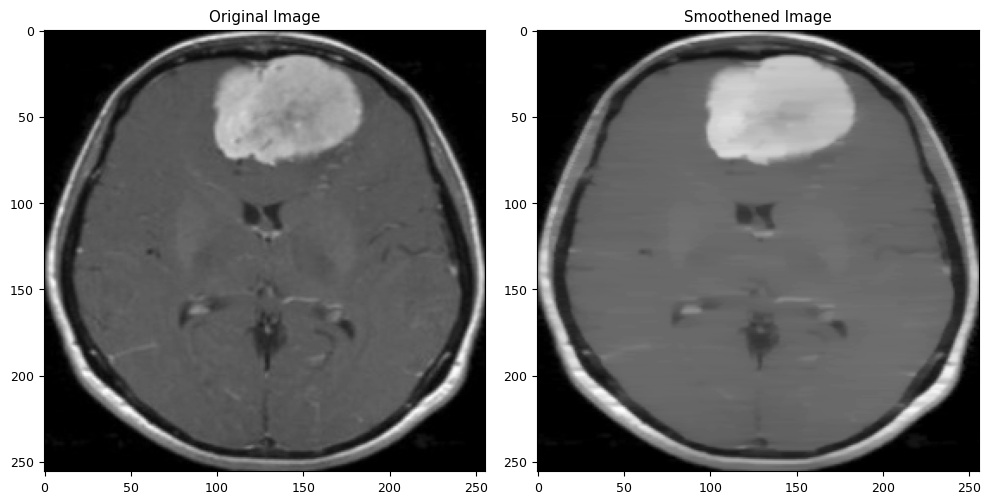

In [74]:
# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# Plot the first grayscale image on the left subplot
plt.subplot(1, 2, 1)
plt.imshow(grayscale_array, cmap='gray')
plt.title('Original Image')

# Plot the second grayscale image on the right subplot
plt.subplot(1, 2, 2)
plt.imshow(sm_img, cmap='gray')
plt.title('Smoothened Image')

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

## Multi-scale Otsu based segmentation
Here we are implementing the multilevel otsu thresholding as described in section 2.2

In [75]:
# Helper function to get neighbors of a pixel (i,j)
def get_neighbors(i, j, shape):
    neighbors = [(x, y) for x in range(i-2, i+3) for y in range(j-2, j+3) if (0 <= x < shape[0] and 0 <= y < shape[1]) and (x, y) != (i, j)]
    return neighbors


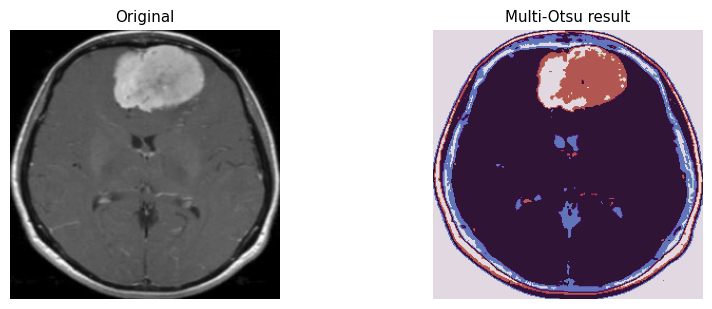

In [76]:
# Applying Otsu Segmentation on the original image
or_img = grayscale_array

thresholds = threshold_multiotsu(or_img, classes = 5)

regions1 = np.digitize(or_img, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

ax[0].imshow(or_img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(regions1, cmap='twilight')
ax[1].set_title('Multi-Otsu result')
ax[1].axis('off')

plt.subplots_adjust()
plt.savefig('or_otsu.png')

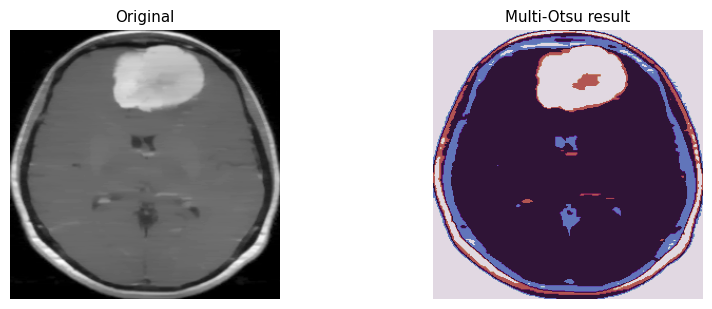

In [77]:
# Applying Otsu on the smooth image
thresholds = threshold_multiotsu(sm_img, classes = 5)

regions2 = np.digitize(sm_img, bins=thresholds)

fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

ax2[0].imshow(sm_img, cmap='gray')
ax2[0].set_title('Original')
ax2[0].axis('off')

ax2[1].imshow(regions2, cmap='twilight')
ax2[1].set_title('Multi-Otsu result')
ax2[1].axis('off')

plt.subplots_adjust()
plt.savefig('sm_otsu.png')

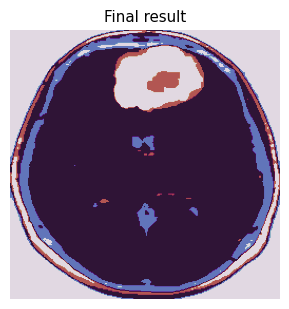

In [78]:
# Using KNN to get the final classes
final_regions = regions1.copy()

for i in range(regions2.shape[0]):
    for j in range(regions2.shape[1]):
        if regions2[i][j] != regions1[i][j]:
            C_i = 0
            C_j = 0
            neighbors = get_neighbors(i, j, regions1.shape)
            for n in neighbors:
                if regions1[n[0]][n[1]] == regions2[n[0]][n[1]]:
                    if regions1[n[0]][n[1]] == regions1[i][j]:
                        C_i += 1
                    elif regions1[n[0]][n[1]] == regions2[i][j]:
                        C_j += 1
            if C_i > C_j:
                final_regions[i][j] = regions1[i][j]
            else:
                final_regions[i][j] = regions2[i][j]

fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(10, 3.5))

ax3.imshow(final_regions, cmap='twilight')
ax3.set_title('Final result')
ax3.axis('off')

plt.subplots_adjust()
plt.savefig('final_regions.png')
plt.show()

np.save('final_regions.npy', final_regions)

## Bi-directional region growing
We implement the section 2.3 here

In [79]:
def region_grow(img_true, init_row, init_col, threshold):
    rows, cols = img_true.shape
    visited = np.zeros((rows, cols))
    queue = []
    classs = img_true[init_row][init_col]
    queue.append((init_row, init_col))
    ans = np.zeros((rows, cols))
    ans[init_row][init_col] = 255
    while len(queue) > 0:
        i, j = queue.pop(0)
        visited[i][j] = 1
        neighbours = get_neighbors(i, j, img_true.shape)
        for neighbour in neighbours:
            if abs(img_true[neighbour[0]][neighbour[1]] - img_true[init_row][init_col]) <= threshold and visited[neighbour[0]][neighbour[1]] == 0:
                queue.append(neighbour)
                ans[neighbour[0]][neighbour[1]] = 255
                visited[neighbour[0]][neighbour[1]] = 1
    return ans

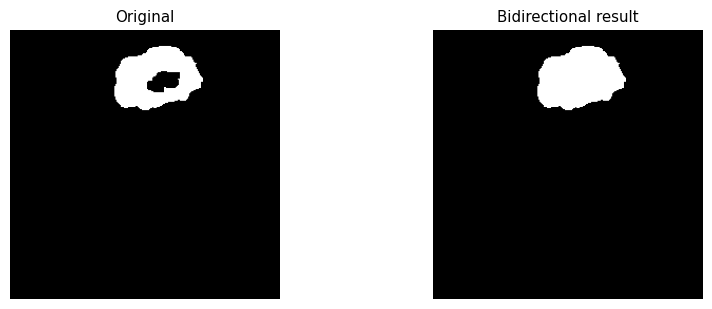

In [80]:
# Region Growing based on manual entry
x = int(input("Enter the row: "))
y = int(input("Enter the column: "))

seed_x = x
seed_y = y

img = region_grow(final_regions, y, x, 0)
new = region_grow(img, 0, 0, 0)
new = 255 - new
img_pred = new

fig4, ax4 = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

ax4[0].imshow(img, cmap='gray')
ax4[0].set_title('Original')
ax4[0].axis('off')

ax4[1].imshow(new, cmap='gray')
ax4[1].set_title('Bidirectional result')
ax4[1].axis('off')

plt.subplots_adjust()
plt.savefig('region_growing.png')
plt.show()

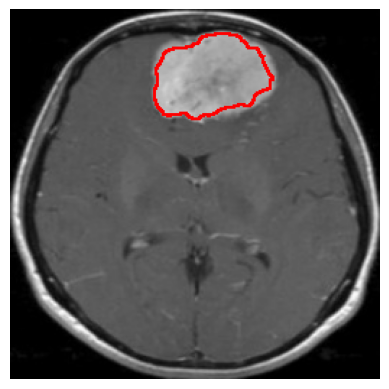

<Figure size 640x480 with 0 Axes>

In [81]:
# Outlining the original image
outline_indices = []

for i in range(new.shape[0]):
    for j in range(new.shape[1]):
        if new[i][j] != 0:
            neighbors = get_neighbors(i, j, new.shape)
            for n in neighbors:
                if new[n[0]][n[1]] == 0:
                    outline_indices.append((i, j))
                    break

colored_image = np.stack((or_img,) * 3, axis=-1)

for i, j in outline_indices:
    colored_image[i, j, 0] = 255
    colored_image[i, j, 1] = 0
    colored_image[i, j, 2] = 0

plt.imshow(colored_image)
plt.axis('off')
plt.show()
plt.savefig('outline.png')

In [82]:
import os
file_size = os.path.getsize(image_path)
s = "19.jpg"  + str(file_size)

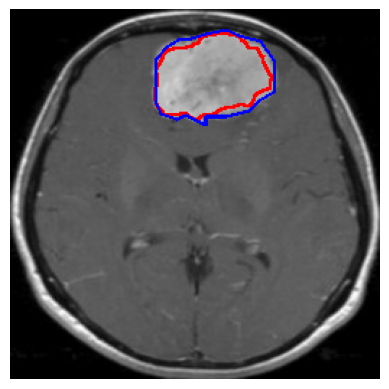

In [83]:
import json
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

# Open the JSON file
with open('./brain-tumor-master/data_cleaned/train/annotations_train.json') as file:
    data = json.load(file)

# Access the data field of s
out_x = data[s]['regions'][0]['shape_attributes']['all_points_x']
out_y = data[s]['regions'][0]['shape_attributes']['all_points_y']
x = np.array([[b,a] for a,b in zip(out_x,out_y)])
ground_outline = x.copy()

for a,b in x:
    neighbors = get_neighbors(a,b,or_img.shape)
    ground_outline = np.append(ground_outline, neighbors, axis = 0)


# Create a list of point tuples
points = x

# Create the Polygon
polygon = Polygon(points)
boundary = LineString(list(polygon.exterior.coords))

# List to store the integer points
integer_points = []

# Iterate over the boundary
for x in range(int(boundary.bounds[0]), int(boundary.bounds[2])+1):
    for y in range(int(boundary.bounds[1]), int(boundary.bounds[3])+1):
        point = Point(x, y)
        if boundary.distance(point) <= 1:  # If the point is on the boundary
            integer_points.append((x, y))

ground_truth = np.stack((or_img,) * 3, axis=-1)
for i, j in integer_points:
    colored_image[i, j, 0] = 0
    colored_image[i, j, 1] = 0
    colored_image[i, j, 2] = 255

plt.imshow(colored_image)
plt.axis('off')
plt.savefig('ground.png', bbox_inches='tight')
plt.show()

## Some Results

True positive rate (TPR) = no. of pixels correctly classified as tumor / true no. of pixels in tumor region

False positive rate (FPR) = no. of pixels incorrectly classified as tumor / true no. of pixels in non-tumor region

Quality = 1 - sqrt(((1 - TPR)^2 + FPR^2)/2) : It ranges from 0 to 1, where 1 indicates perfect segmentation


In [84]:
def error_matric(img_true, img_pred):
    tpr = np.sum(np.logical_and(img_true == 255, img_pred == 255)) / np.sum(img_true == 255)
    fpr = np.sum(np.logical_and(img_true == 0, img_pred == 255)) / np.sum(img_true == 0)
    Q = 1 - np.sqrt(((1 - tpr)**2 + fpr**2)/2)
    return tpr, fpr, Q


In [85]:
import matplotlib.path as mplPath
img_true = np.zeros(or_img.shape)

rows, cols = img_true.shape
visited = np.zeros((rows, cols))
queue = []
queue.append((seed_x, seed_y))
ans = np.zeros((rows, cols))
ans[seed_x][seed_y] = 255
while len(queue) > 0:
    i, j = queue.pop(0)
    visited[i][j] = 1
    neighbours = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
    for neighbour in neighbours:
        if neighbour[0] >= 0 and neighbour[0] < rows and neighbour[1] >= 0 and neighbour[1] < cols and visited[neighbour[0]][neighbour[1]] == 0:
            if neighbour not in integer_points and visited[neighbour[0]][neighbour[1]] == 0:
                queue.append(neighbour)
                ans[neighbour[0]][neighbour[1]] = 255
                visited[neighbour[0]][neighbour[1]] = 1

img_true.shape
img_true = 255 - ans

In [86]:
tpr, fpr, Q = error_matric(img_true, img_pred)
print("True Positive Rate: ", tpr)
print("False Positive Rate: ", fpr)
print("Quality: ", Q)


True Positive Rate:  0.8523657870791629
False Positive Rate:  0.00019627085377821394
Quality:  0.8956067546557654
